In [6]:
from matplotlib import pyplot as plt
import torch
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import load_boston
import warnings
from typing import Union
import time
import seaborn
from torch import nn


#### 建立数据类

In [7]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    boston = load_boston()
scaler = StandardScaler()
feature = scaler.fit_transform(boston.data)


In [48]:
class DataSet(object):
    def __init__(self, feature:torch.Tensor=None, label:torch.Tensor=None, n_train:Union[int,float]=0.8) -> None:
        self.feature = feature
        self.label = label
        self.n_train = n_train
    
    def setData(self, feature:torch.Tensor, label:torch.Tensor, f_dtype=torch.float32, l_dtype=torch.float32)->torch.Tensor:
        self.feature = torch.tensor(feature,dtype=f_dtype)
        self.label = torch.tensor(label, dtype=l_dtype)

    def get_tensorloader(self, tensors, train:bool, indices=slice(0,None),batch_size=8)->DataLoader:
        # 将所有tensor->(X,y)分别取出放入元组
        tensors = tuple(a[indices] for a in tensors)
        # 利用TensorDataSet将其进行整合
        data = TensorDataset(*tensors)
        # 是取训练集将打乱,测试集则不用打乱
        if train:
            return DataLoader(data, batch_size, shuffle=train)
        else:
            return DataLoader(data, self.feature.shape[0] - self.n_train)

    def get_dataloader(self, batch_size=8, train:bool=True)->DataLoader:
        if type(self.n_train) is float:
            self.n_train = int(self.n_train * self.feature.shape[0])
        i = slice(0, self.n_train) if train else slice(self.n_train, None)
        return self.get_tensorloader((self.feature, self.label), train, i, batch_size)
    
dataloader = DataSet()

dataloader.setData(feature,boston.target)


#### torch高级API实现线性回归

In [63]:
class TorchLinearRegression():
    def __init__(self, lr=0.001) -> None:
        self.lr = lr
        self.net = nn.LazyLinear(1)
        self.net.weight.data.normal_(0,0.1)
        self.net.bias.data.fill_(0)
    
    def loss(self, y:torch.Tensor, y_hat:torch.Tensor)->torch.Tensor:
        fn = nn.MSELoss()
        return fn(y.reshape(y_hat.shape), y_hat)
    
    def forward(self, X:torch.Tensor)->torch.Tensor:
        return self.net(X)

    def fit(self, data:DataSet, lr=0.001, batch_size=8, epochs=10, train:bool=True)->torch.Tensor:
        self.lr = lr
        optimizer = self.configure_optimizer()
        for epoch in range(epochs):
            for train_data in data.get_dataloader(batch_size,train):
                optimizer.zero_grad()
                l = self.loss(train_data[1],self.forward(train_data[0]))
                l.backward()
                optimizer.step()

    def configure_optimizer(self,):
        return torch.optim.SGD(self.net.parameters(), self.lr)

In [64]:
reg = TorchLinearRegression()

reg.fit(dataloader,epochs=50)


e:\ProgramData\Anaconda3\envs\pytorchenv\lib\site-packages\torch\nn\modules\lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


tensor(41.8989, grad_fn=<MseLossBackward0>)


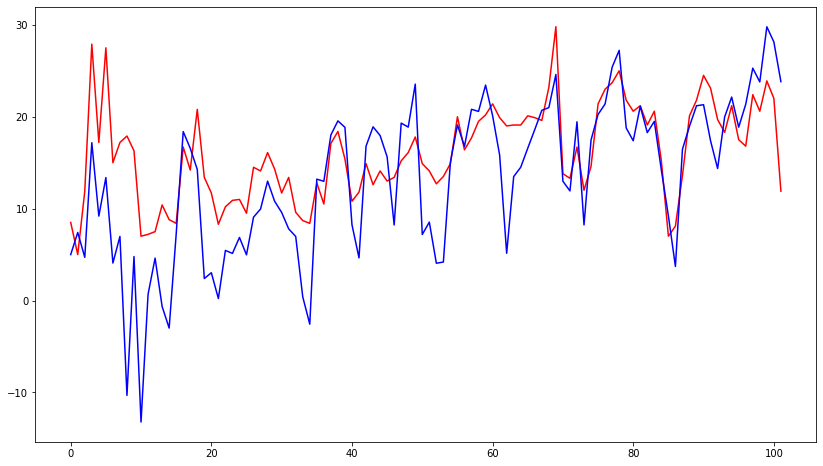

In [73]:
plt.figure(figsize=(14,8))
for train_data in dataloader.get_dataloader(train=False):
    plt.plot(train_data[1],linewidth=1.5, color='r')
    plt.plot(reg.forward(train_data[0]).detach().numpy(), linewidth=1.5, color='b')

print(reg.loss(train_data[1], reg.forward(train_data[0])))

#### 正则化

In [89]:
class WeightDecay(TorchLinearRegression):
    def __init__(self, lambd, lr=0.001) -> None:
        super().__init__(lr)
        self.lambd = lambd
    
    def l2_penalty(self, w:torch.Tensor)->torch.Tensor:
        return (w ** 2).sum() / 2
    
    def loss(self, y, y_hat)->torch.Tensor:
        return super().loss(y, y_hat) + self.lambd * self.l2_penalty(self.net.weight.data)
    def fit(self, data:DataSet, lr=0.001, batch_size=8, epochs=10, train:bool=True)->torch.Tensor:
        self.lr = lr
        optimizer = self.configure_optimizer()
        for epoch in range(epochs):
            for train_data in data.get_dataloader(batch_size,train):
                optimizer.zero_grad()
                l = self.loss(train_data[1],self.forward(train_data[0]))
                l.backward()
                optimizer.step()


In [94]:
reg_l2 = WeightDecay(0.1)
reg_l2.fit(dataloader,epochs=50)

e:\ProgramData\Anaconda3\envs\pytorchenv\lib\site-packages\torch\nn\modules\lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


tensor(45.7504, grad_fn=<AddBackward0>)


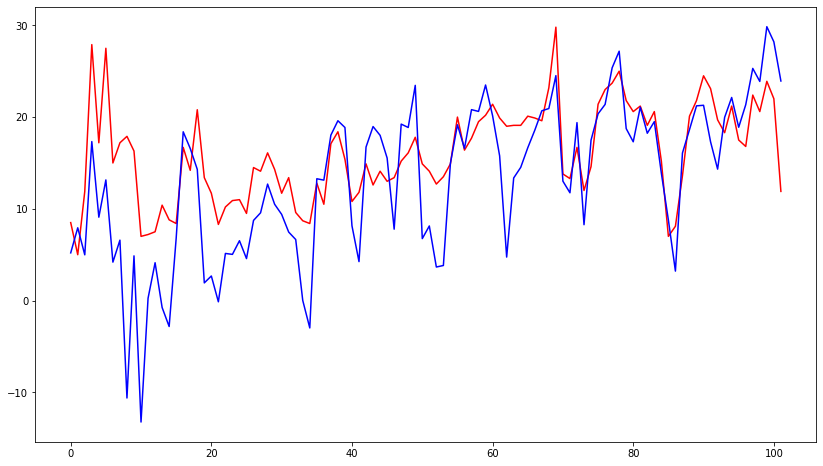

In [95]:
plt.figure(figsize=(14,8))
for train_data in dataloader.get_dataloader(train=False):
    plt.plot(train_data[1],linewidth=1.5, color='r')
    plt.plot(reg_l2.forward(train_data[0]).detach().numpy(), linewidth=1.5, color='b')

print(reg_l2.loss(train_data[1],reg_l2.forward(train_data[0])))